# Fix velocity calculation - check 
After noticing that the calculations of the angular velocity were false -> new attempt.
Calculating angle between two vectors in time V1, V2 and determining if the movement is clock wise or counted clockwise:

if (v1.y * v2.x > v1.x *v2.y):
    return anticlockwise
  else:
      return clockwise
  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate


%matplotlib inline
sns.set(color_codes=True)
pd.options.mode.chained_assignment = None 

# data loading
path = '../datasets/preprocessed/'
# dfrat     = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')

dfrat     = pd.read_hdf(path+'filteredDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions').set_index('index')

In [2]:
## VECTORS WITHOUT Y
dfOri = pd.DataFrame()

for name, dd in dfrat.groupby('session_id'):
    dd['dT'] = dd['Time'].diff(1)
    
    # calculating lenghts of VecX and VecZ and creation of shifted vectors  #dd = dd.apply(decompose_vec_df, axis=1)
    dd['lVo'] = np.linalg.norm(np.array([dd.X_Ori, dd.Y_Ori, dd.Z_Ori])  )
    dd['lx1'] = dd['X_Ori'] / dd['lVo']
    dd['lz1'] = dd['Z_Ori'] / dd['lVo']
    
    # normalize the data to unit vector form
    dd['V1'] = np.linalg.norm(np.array([dd.lx1, 0, dd.lz1]))
    dd['lx1'] = dd.lx1 / dd.V1
    dd['lz1'] = dd.lz1 / dd.V1

    dfOri = pd.concat([dfOri, dd], axis=0, ignore_index=True)

dfOri = dfOri.replace([np.inf, -np.inf], np.nan).dropna()# print(dfOri)

In [3]:
## ANGLES and VELOCITY
dfOri2 = pd.DataFrame()

# calculatinig the angles between X axis and the vectors
for name, dd in dfOri.groupby('session_id'):
    dd['lx2'] = dd.lx1.shift(1)
    dd['lz2'] = dd.lz1.shift(1)
    
    V1 = np.array([dd.lx1, 0, dd.lz1])
    V3 = np.array([dd.lx2, 0, dd.lz2])
    
    dd['clockwise'] = dd.lz1 * dd.lx2 < dd.lx1 * dd.lz2
    dd.clockwise = dd.clockwise.astype(int)
    dd.clockwise = dd.clockwise.replace(to_replace=0, value=-1)
    dd.clockwise
    
#   theta0 = np.arccos(lx1*1 + lz1*0 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
#     dd['theta'] = np.arccos(dd.lx1*dd.lx2 + dd.lz1*dd.lz2 / (np.linalg.norm(V1) * np.linalg.norm(V3)))
    dd['a'] = np.dot(V1, V3) / (np.linalg.norm(V1) * np.linalg.norm(V3))
    dd['theta'] = np.arccos(np.dot(V1, V3) / (np.linalg.norm(V1) * np.linalg.norm(V3)))

    # angular velocity between two vectors
    dd['U'] = np.degrees(dd.theta * dd.clockwise)/ dd.dT       
    dfOri2 = pd.concat([dfOri2, dd], axis=0, ignore_index=True)    

dfOri2 = dfOri2.replace([np.inf, -np.inf], np.nan).dropna()

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in arccos


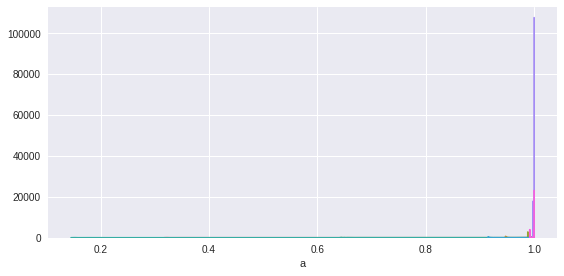

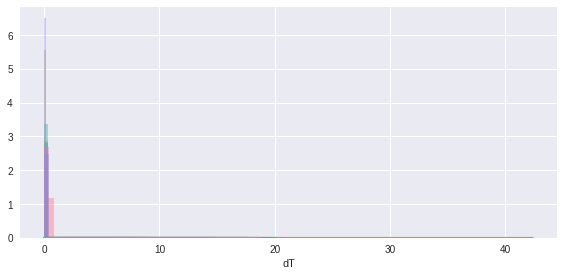

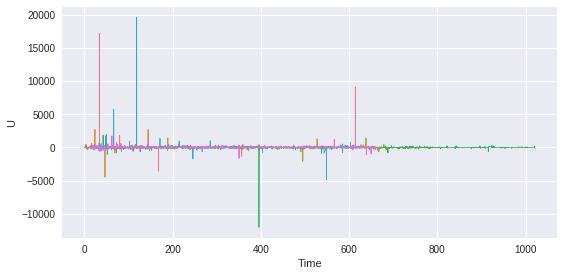

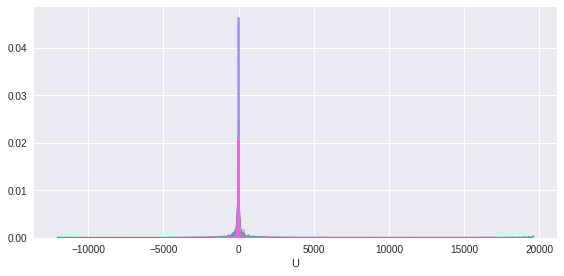

In [4]:
# filtered
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'a');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'dT');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');


In [5]:
dfOriU = pd.DataFrame()
dfOri2 = dfOri2[np.absolute(dfOri2['dT']) < 0.005] # filtering out big time gaps frame points

for name, dd in dfOri2.groupby('session_id'):
    dd['UM'] = dd['U'].rolling(window=20).mean()
    dfOriU = pd.concat([dfOriU, dd], axis=0, ignore_index=True)    

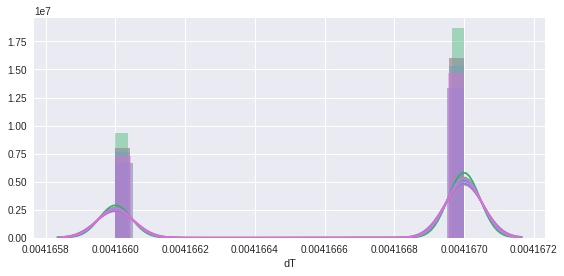

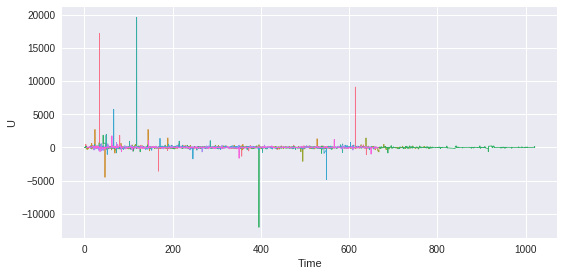

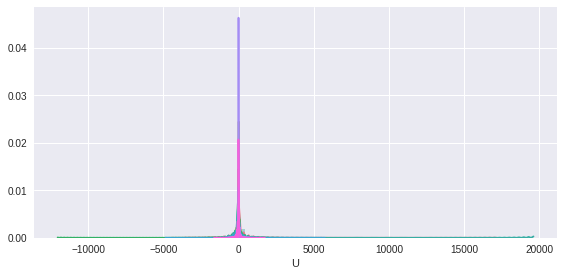

In [6]:
# filtered
g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'dT');

g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);
g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');


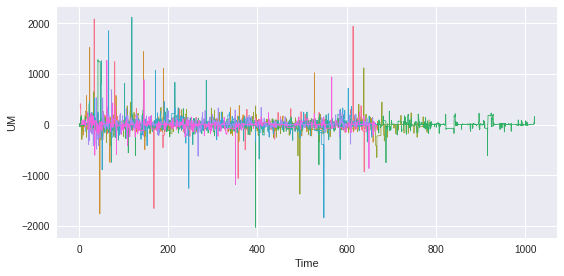

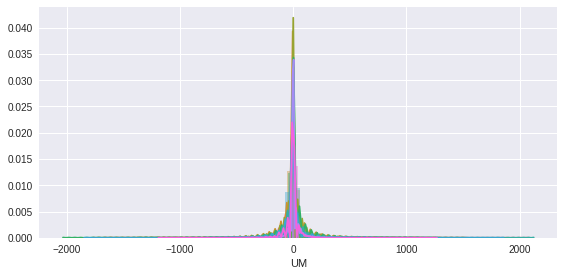

In [7]:
# smoothed
g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);
g = sns.FacetGrid(hue='session_id', data=dfOriU, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'UM');

In [20]:
df = pd.merge(dfOriU, dfevent, on=['Frame', 'session_id','Time'])
df['UM'] = df['U'].rolling(window=20, center=True).mean()

df['subU'] = df['speed'] - df['U'] 
df['subUM'] = df['speed'] - df['UM'] 


## Experiment 2

In [9]:
dd2 = df[df['session_id']==2]

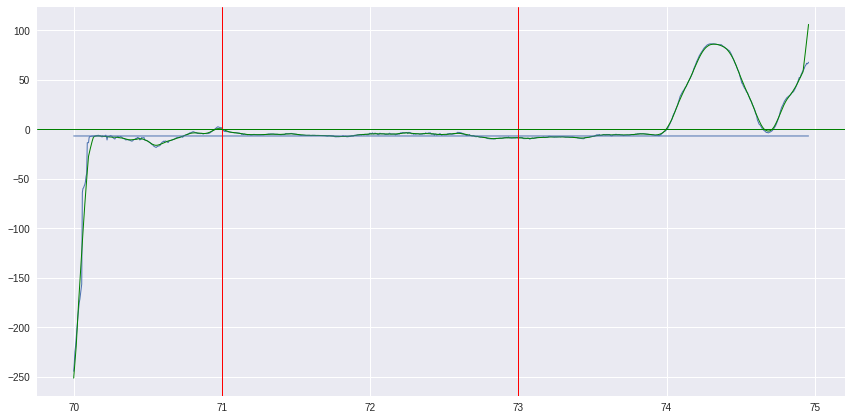

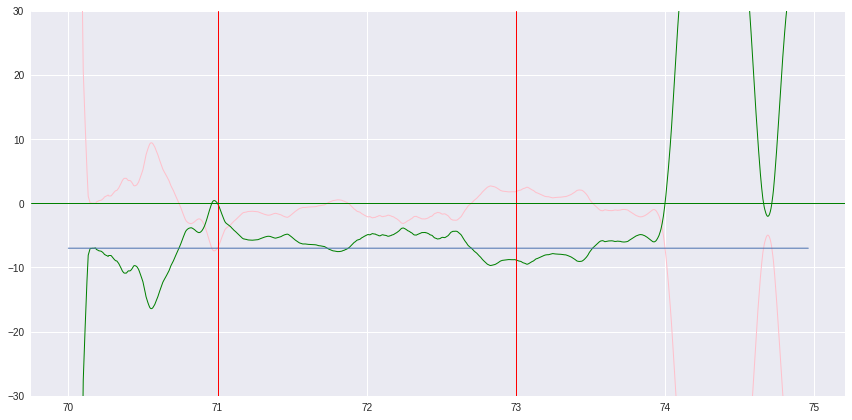

In [10]:
#  71, 73
dpart = dd2[(dd2['Time']>70) & (dd2['Time']<75)]
xmin, xmax = 71, 73

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
# g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

g = sns.FacetGrid(data=dpart, size=6, aspect=2, ylim=[-30,30])
# g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1, color='pink');
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


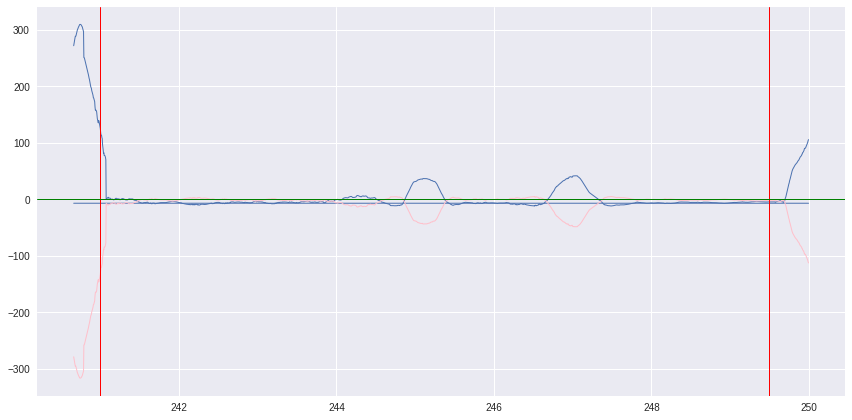

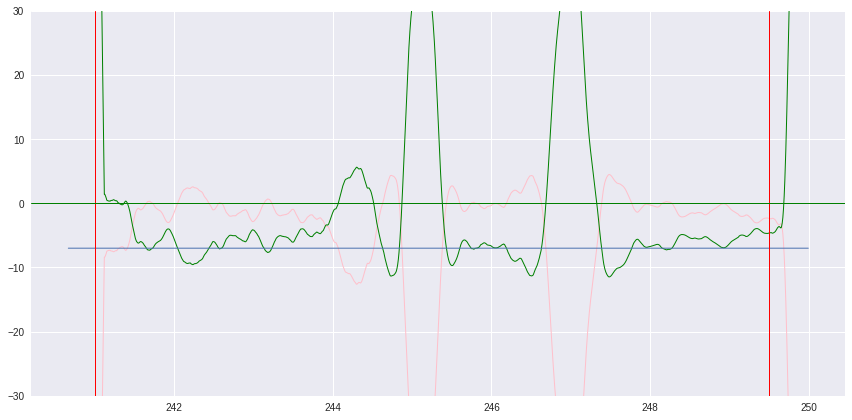

In [11]:

## 247, 249
dpart = dd2[(dd2['Time']>240) & (dd2['Time']<250)]
xmin, xmax = 241, 249.5

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

g = sns.FacetGrid(data=dpart, size=6, aspect=2, ylim=[-30,30])
# g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1, color='pink');
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');



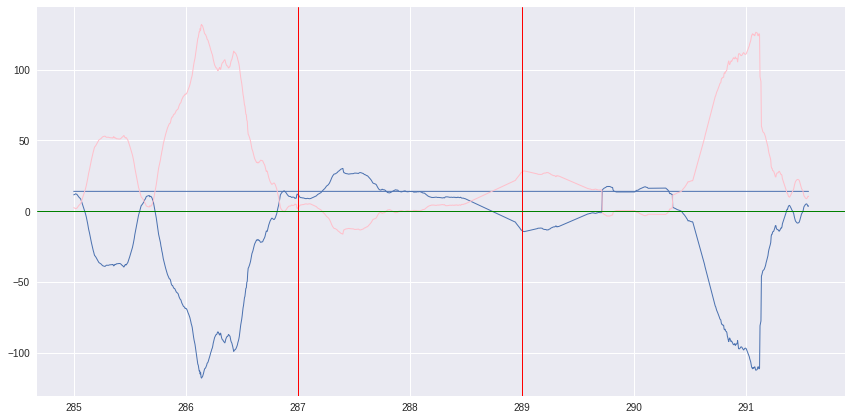

In [12]:
## 287, 289
dpart = dd2[(dd2['Time']>285) & (dd2['Time']<292)]
xmin, xmax = 287, 289

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


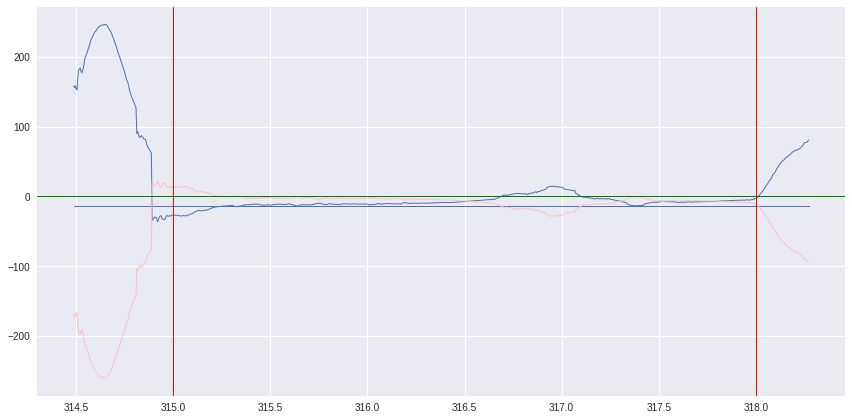

In [13]:
## 315, 317
dpart = dd2[(dd2['Time']>313) & (dd2['Time']<320)]
xmin, xmax = 315, 318

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


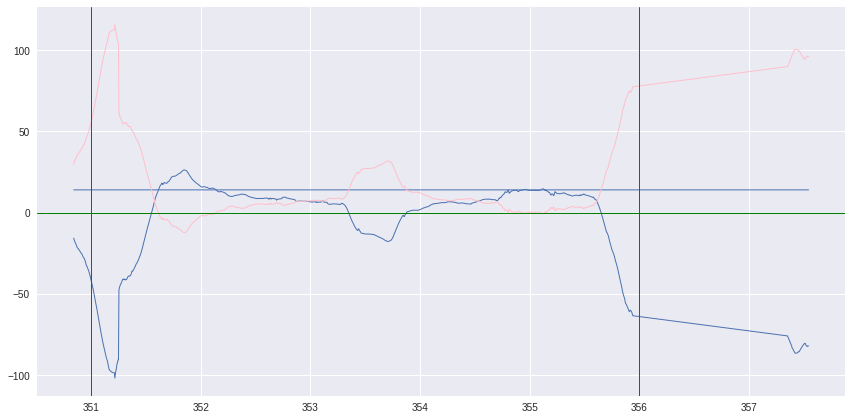

In [14]:
## 351, 356
dpart = dd2[(dd2['Time']>350) & (dd2['Time']<358)]
xmin, xmax = 351, 356

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


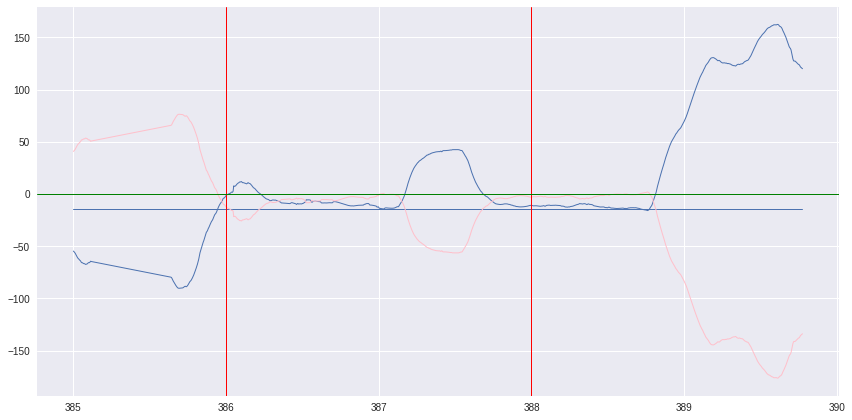

In [15]:
## 386, 388
dpart = dd2[(dd2['Time']>385) & (dd2['Time']<390)]
xmin, xmax = 386, 388

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


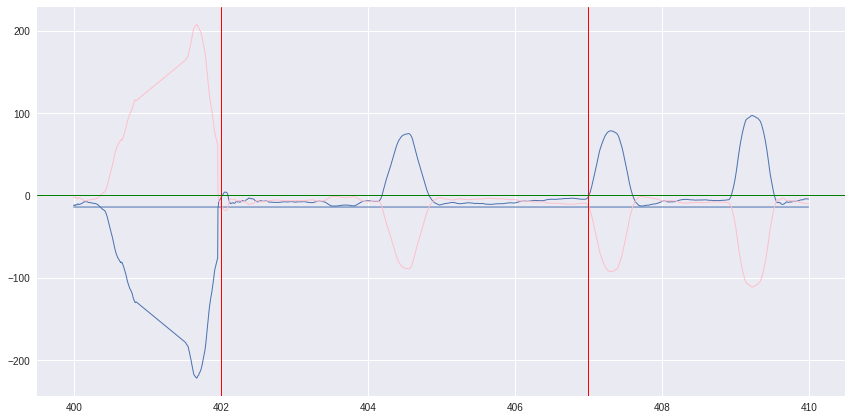

In [16]:
## 402, 407
dpart = dd2[(dd2['Time']>400) & (dd2['Time']<410)]
xmin, xmax = 402, 407

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');



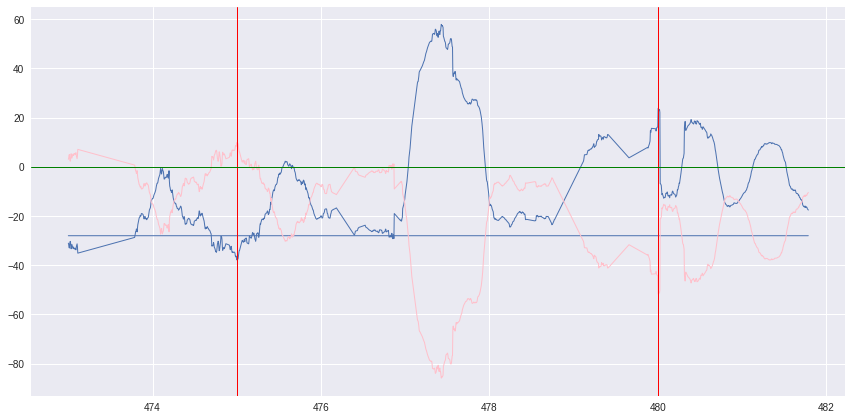

In [17]:
## 475, 480
dpart = dd2[(dd2['Time']>473) & (dd2['Time']<482)]
xmin, xmax = 475, 480

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


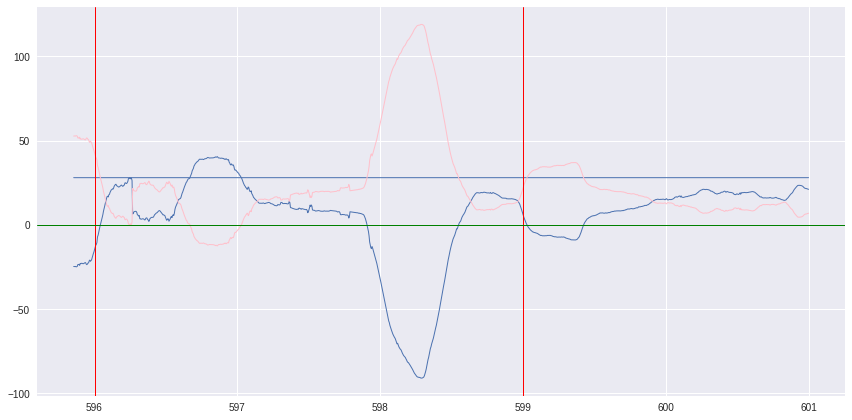

In [18]:
## 596, 597, 589, 599
dpart = dd2[(dd2['Time']>595) & (dd2['Time']<601)]
xmin, xmax = 596, 599

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');



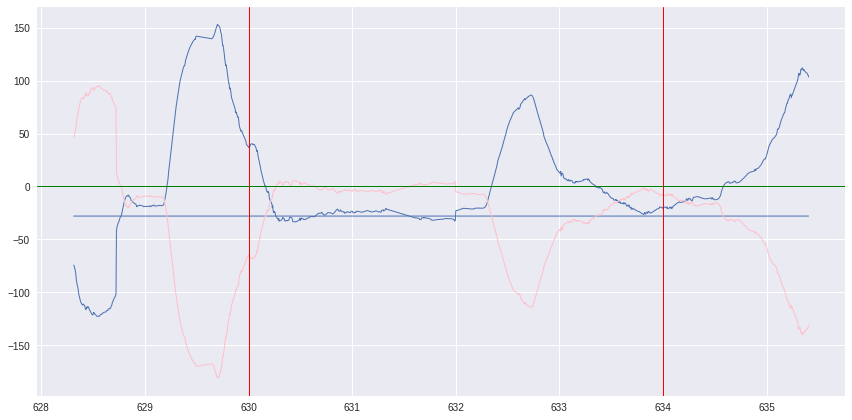

In [19]:
## 630, 632, 633, 634
dpart = dd2[(dd2['Time']>628) & (dd2['Time']<636)]
xmin, xmax = 630, 634

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


## Experiment 4

In [21]:
dd4 = df[df['session_id']==4]

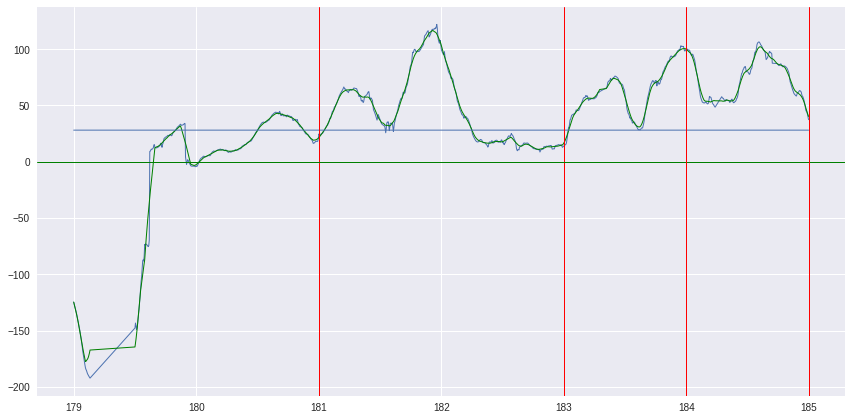

In [28]:
# 181, 183, 184, 185
dpart = dd4[(dd4['Time']>179) & (dd4['Time']<185)]
xmin, xmax =  181, 183

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
# g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

xmin, xmax =  184, 185
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');


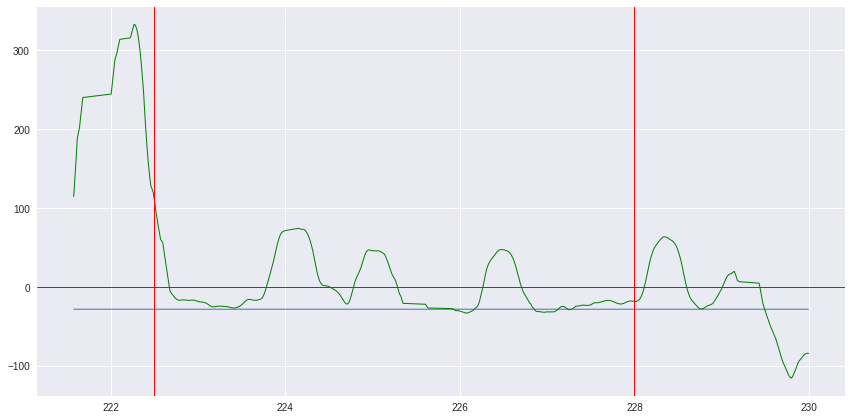

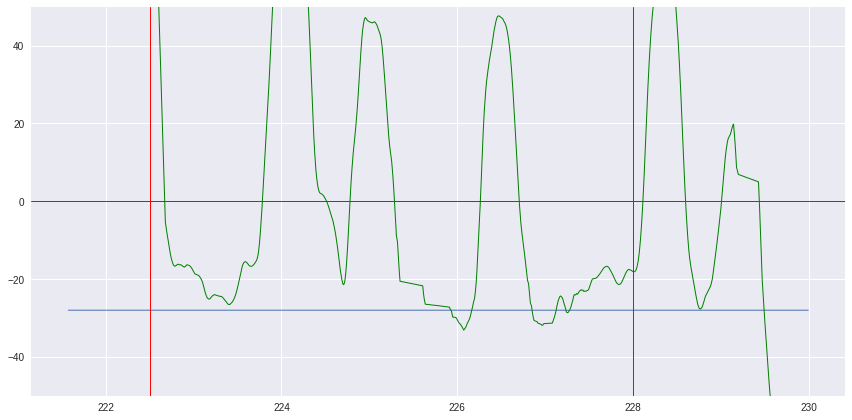

In [30]:
# 221, 228
dpart = dd4[(dd4['Time']>219) & (dd4['Time']<230)]
xmin, xmax = 222.5, 228

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
# g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
# g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

g = sns.FacetGrid(data=dpart, size=6, aspect=2, ylim=[-50,50])
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


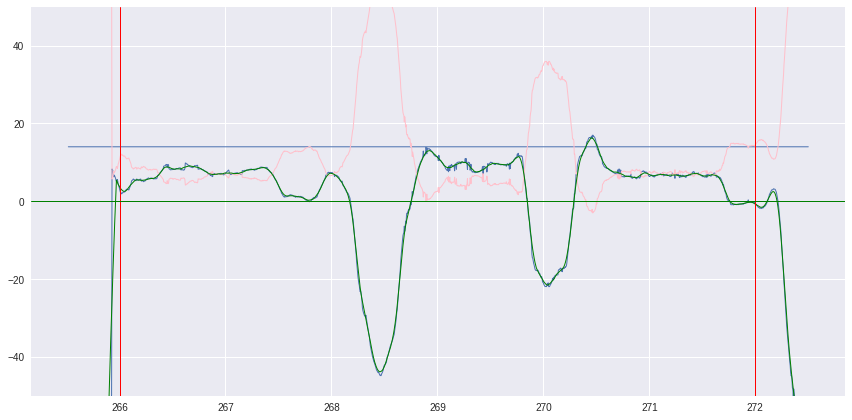

In [24]:
# 267, 270
dpart = dd4[(dd4['Time']>265) & (dd4['Time']<275)]
xmin, xmax = 266, 272

g = sns.FacetGrid(data=dpart, size=6, aspect=2, ylim=[-50,50])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');

g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


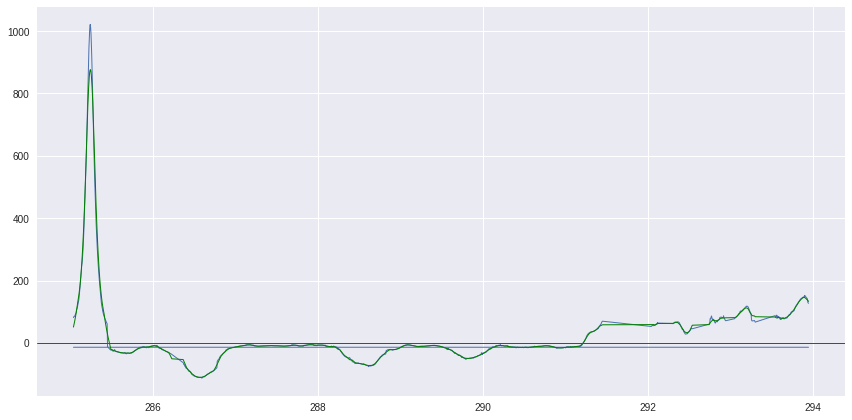

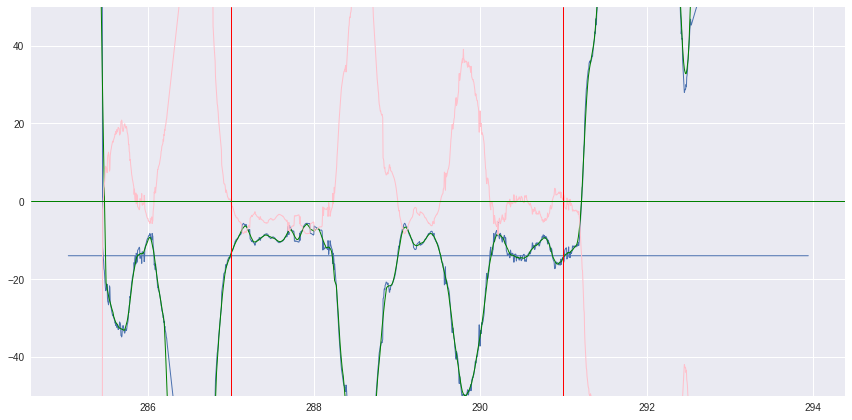

In [25]:
# 287, 291
dpart = dd4[(dd4['Time']>285) & (dd4['Time']<295)]
xmin, xmax = 287, 291

g = sns.FacetGrid(data=dpart, size=6, aspect=2)
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

g = sns.FacetGrid(data=dpart, size=6, aspect=2, ylim=[-50,50])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=1, color='green');

g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1, color='pink');
g.map(plt.axvline, x=xmin, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=xmax, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');
